In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=a2vvHeFgVtCp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


In [88]:
from source.IB_connector import retrive_market_data

ticker = "AAPL"
training_set_aapl = retrive_market_data([ticker], duration = "7 d", time_interval = "15 mins")
training_set = training_set_aapl[ticker]
training_set['Volume'] = training_set['Volume'].astype(float)
training_set['Date'] = pd.to_datetime(training_set['Date'].str.replace(' US/Eastern',''),format="%Y%m%d %H:%M:%S")

ERROR -1 2104 Market data farm connection is OK:usfarm.nj
ERROR -1 2104 Market data farm connection is OK:usfuture
ERROR -1 2104 Market data farm connection is OK:cashfarm
ERROR -1 2104 Market data farm connection is OK:usfarm
ERROR -1 2106 HMDS data farm connection is OK:ushmds
ERROR -1 2158 Sec-def data farm connection is OK:secdefil


In [90]:
test_dates = training_set['Date'].values
training_set_aapl[ticker] # ['Open','High','Low','Close','Volume']

,Date,Open,High,Low,Close,Volume
0,2025-05-12 09:30:00,210.93,211.26,206.75,207.39,7054261.0
1,2025-05-12 09:45:00,207.40,208.55,207.30,208.53,2849437.0
2,2025-05-12 10:00:00,208.53,209.96,208.46,209.85,2799331.0
3,2025-05-12 10:15:00,209.86,210.09,208.56,209.16,2616286.0
4,2025-05-12 10:30:00,209.17,209.77,208.48,209.76,1397362.0
...,...,...,...,...,...,...
167,2025-05-20 12:15:00,207.71,207.92,207.57,207.81,466264.0
168,2025-05-20 12:30:00,207.81,208.02,207.71,207.96,476646.0
169,2025-05-20 12:45:00,207.95,207.99,207.58,207.61,412070.0
170,2025-05-20 13:00:00,207.61,207.74,207.38,207.43,528631.0


In [87]:
training_set = training_set[['Open','High','Low','Close','Volume']]
training_set.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [12]:
#training_set = training_set.loc[:,['Open','High','Low','Close','Volume']].values

In [61]:
n = len(training_set)
train_df = training_set#training_set[0:int(n*0.4)]
val_df = training_set[int(n*0.4):int(n*0.5)]

rl_df = training_set[int(n*0.5):int(n*0.9)]

test_df = training_set[int(n*0.9):]

In [7]:
rl_df

,Open,High,Low,Close,Volume
2133,137.80,138.19,137.52,137.73,7500808.0
2134,139.23,139.76,137.74,138.96,15453947.0
2135,138.95,140.20,138.64,138.99,10371728.0
2136,139.07,139.07,137.20,137.35,7720892.0
2137,137.36,138.51,137.08,138.51,5630273.0
...,...,...,...,...,...
3834,105.30,105.43,105.03,105.43,4031653.0
3835,105.43,105.88,105.34,105.75,4525438.0
3836,105.74,106.22,105.70,105.84,5774852.0
3837,105.84,106.27,105.67,106.16,4799109.0


In [62]:
train_df

,Open,High,Low,Close,Volume
0,210.93,211.26,206.75,207.39,7054261.0
1,207.40,208.55,207.30,208.53,2849437.0
2,208.53,209.96,208.46,209.85,2799331.0
3,209.86,210.09,208.56,209.16,2616286.0
4,209.17,209.77,208.48,209.76,1397362.0
...,...,...,...,...,...
167,207.71,207.92,207.57,207.81,466264.0
168,207.81,208.02,207.71,207.96,476646.0
169,207.95,207.99,207.58,207.61,412070.0
170,207.61,207.74,207.38,207.43,528631.0


In [115]:
train_mean = train_df.mean()
train_std = train_df.std()

In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

sc = MinMaxScaler()


train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

In [15]:
import tensorflow as tf


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class WindowDataset(Dataset):
    def __init__(self, data, window_generator):
        """
        data: Oryginalne dane do generowania sekwencji (np. np.array lub torch.tensor)
        window_generator: Obiekt klasy WindowGenerator, który ma metodę split_window
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # konwersja na tensor
        self.window_generator = window_generator
        self.total_window_size = window_generator.total_window_size

    def __len__(self):
        return len(self.data) - self.total_window_size + 1

    def __getitem__(self, idx):
        window = self.data[idx:idx + self.total_window_size]  # tworzenie okna
        window = window.unsqueeze(0)  # Dodajemy wymiar batchu
        self.inputs, self.labels = self.window_generator.split_window(window)
        return self.inputs.squeeze(0), self.labels.squeeze(0)  # Usuwamy wymiar batchu, by były [time, features]
        


class WindowGenerator():
	def __init__(self, input_width, label_width, shift,
				 train_df=train_df, val_df=val_df, test_df=test_df,
				 label_columns=None):
		# Store the raw data.
		self.train_df = train_df
		self.val_df = val_df
		self.test_df = test_df

		# Work out the label column indices.
		self.label_columns = label_columns
		if label_columns is not None:
			self.label_columns_indices = {name: i for i, name in
										  enumerate(label_columns)}
		self.column_indices = {name: i for i, name in
							   enumerate(train_df.columns)}

		# Work out the window parameters.
		self.input_width = input_width
		self.label_width = label_width
		self.shift = shift

		self.total_window_size = input_width + shift

		self.input_slice = slice(0, input_width)
		self.input_indices = np.arange(self.total_window_size)[self.input_slice]

		self.label_start = self.total_window_size - self.label_width
		self.labels_slice = slice(self.label_start, None)
		self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

	def __repr__(self):
		return '\n'.join([
			f'Total window size: {self.total_window_size}',
			f'Input indices: {self.input_indices}',
			f'Label indices: {self.label_indices}',
			f'Label column name(s): {self.label_columns}'])

	def split_window(self, features):
		inputs = features[:, self.input_slice, :]
		labels = features[:, self.labels_slice, :]
		if self.label_columns is not None:
			labels = torch.stack(
				[labels[:, :, self.column_indices[name]] for name in self.label_columns],
				axis=-1)

		# Slicing doesn't preserve static shape information, so set the shapes
		# manually. This way the `tf.data.Datasets` are easier to inspect.
		#inputs.set_shape([None, self.input_width, None])
		#labels.set_shape([None, self.label_width, None])

		return inputs, labels

	def plot(self, predictions=None, plot_col='Close', max_subplots=10):
		inputs, labels = self.example
		plt.figure(figsize=(12, 8))
		plot_col_index = self.column_indices[plot_col]
		max_n = min(max_subplots, len(inputs))
		for n in range(max_n):
			plt.subplot(max_n, 1, n + 1)
			plt.ylabel(f'{plot_col} [normed]')
			plt.plot(self.input_indices, inputs[n, :, plot_col_index],
					 label='Inputs', marker='.', zorder=-10)

			if self.label_columns:
				label_col_index = self.label_columns_indices.get(plot_col, None)
			else:
				label_col_index = plot_col_index

			if label_col_index is None:
				continue

			plt.scatter(self.label_indices, labels[n, :, label_col_index],
						edgecolors='k', label='Labels', c='#2ca02c', s=64)
			if predictions is not None:
				#predictions = model(inputs)
				#predictions = predictions.detach().numpy()
				plt.scatter(self.label_indices, predictions[n, :, label_col_index],
							marker='X', edgecolors='k', label='Predictions',
							c='#ff7f0e', s=64)

			if n == 0:
				plt.legend()

		plt.xlabel('Time [h]')
  
	def make_dataset(self, data):
		"""
		Tworzy dataset na podstawie danych i okna z klasy WindowGenerator.
		"""
		dataset = WindowDataset(data, self)  # Tworzymy dataset z danymi i WindowGenerator
		return dataset



In [17]:
OUT_STEPS = 16


w1 = WindowGenerator(input_width=48, label_width=OUT_STEPS, shift=OUT_STEPS, 
                    train_df=train_df, val_df=val_df, test_df=test_df, 
                    label_columns=['Close'])
# Stworzenie datasetu:
train_dataset = w1.make_dataset(train_df.values)  # Zakładając, że train_df to np. pandas.DataFrame
val_dataset = w1.make_dataset(val_df.values)  # Zakładając, że train_df to np. pandas.DataFrame


In [ ]:


# DataLoader:
BATCH_SIZE = 512 # 256 * 2 = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

ValueError: __len__() should return >= 0

In [95]:
# Zbiera wszystkie batch'e w jeden tensor
stacked_inputs = []
stacked_labels = []

for inputs, labels in val_loader:
    stacked_inputs.append(inputs)
    stacked_labels.append(labels)

# Stackowanie danych na jednym tensorze
stacked_inputs = torch.cat(stacked_inputs, dim=0)  # Stackowanie po wymiarze batch
stacked_labels = torch.cat(stacked_labels, dim=0)  # Stackowanie po wymiarze batch

NameError: name 'val_loader' is not defined

In [13]:
# example_window = torch.stack([
# 	# torch.tensor(train_df[:w1.total_window_size].values, dtype=torch.float32),
# 	# torch.tensor(train_df[50:50+w1.total_window_size].values, dtype=torch.float32),
# 	# torch.tensor(train_df[100:100+w1.total_window_size].values, dtype=torch.float32)
# ])

example_inputs, example_labels = stacked_inputs,stacked_labels #w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
#print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Inputs shape: torch.Size([364, 48, 5])
Labels shape: torch.Size([364, 16, 1])


In [94]:
w1.example = example_inputs, example_labels
w1.plot()

NameError: name 'example_inputs' is not defined

In [64]:
class MultiLSTMModel(nn.Module):
	def __init__(self, input_size, lstm_units, out_steps, num_features):
		super(MultiLSTMModel, self).__init__()
		self.out_steps = out_steps
		self.num_features = num_features

		self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_units, batch_first=True)
		#self.lstm2 = nn.LSTM(input_size=lstm_units, hidden_size=32, batch_first=True)
		self.fc = nn.Linear(lstm_units, 32)
		self.fc2 = nn.Linear(32, out_steps)

		#nn.init.zeros_(self.fc.weight)  # <- zero kernel initializer
		#nn.init.zeros_(self.fc.bias)
	def forward(self, x):
		# x: [batch, time, features]
		_, (h_n, _) = self.lstm(x)  # h_n: [1, batch, lstm_units]
		h_n = h_n.squeeze(0)        # [batch, lstm_units]

		#_, (h_n, _) = self.lstm2(h_n)  # h_n: [1, batch, lstm_units]
		#h_n = h_n.squeeze(0)        # [batch, lstm_units]

		x = self.fc(h_n)            # [batch, out_steps * num_features]
		x = self.fc2(x)		# [out_steps * num_features, close_price]
		x = x.view(-1, self.out_steps, 1)
		return x

class MAPELoss(nn.Module):
	def __init__(self, epsilon=1e-8):
		super(MAPELoss, self).__init__()
		self.epsilon = epsilon  # small value to avoid division by zero

	def forward(self, pred, target):
		return torch.mean(torch.abs((target - pred) / (target + self.epsilon))) * 100

In [19]:
num_epochs = 2000
learning_rate = 0.014

num_features = 5
input_size = num_features
lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm.to(device)

MultiLSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [ ]:
#criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
criterion = MAPELoss()
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
  
    for inputs, labels in train_loader:
      # print(inputs.shape)  # [batch, time, features]
      # print(labels.shape)  # [batch, label_width, features]
      inputs = inputs.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = lstm(inputs)
      optimizer.zero_grad()
      # obtain the loss function
      loss = criterion(outputs, labels)
      
      loss.backward()
      
      optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))



In [59]:
torch.save(lstm.state_dict(), "lstm_model_aapl.pth")

In [96]:
OUT_STEPS = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lstm = MultiLSTMModel(input_size=input_size, lstm_units=32, out_steps=OUT_STEPS, num_features=num_features)
lstm.load_state_dict(torch.load("lstm_model_aapl.pth", weights_only=True))
lstm.eval()
lstm.to(device)

MultiLSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
)

In [97]:
val_dataset.data.shape

torch.Size([7, 5])

In [98]:
#predict = lstm(val_dataset.data)
i = 0 
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = lstm(inputs)
    
    loss = criterion(outputs, labels)    
    leb = labels.detach().cpu().numpy()*train_std[3] + train_mean[3]
    pred = outputs.detach().cpu().numpy()*train_std[3] + train_mean[3]
    print(loss.item())
    print("MAPE ", np.mean(np.abs(leb - pred) / leb * 100) )
    print("MAE ", np.mean(np.abs(leb - pred)) )



NameError: name 'val_loader' is not defined

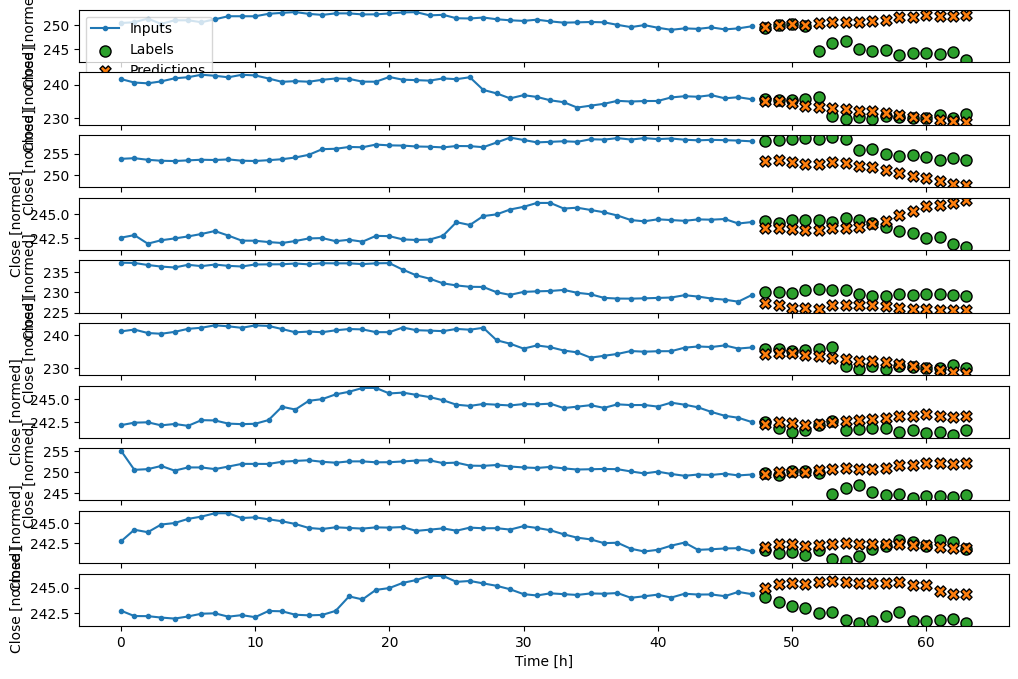

In [19]:
inpu = inputs.detach().cpu().numpy()*train_std[3] + train_mean[3]

w1.example = inpu, leb

w1.plot(pred, max_subplots=10)

In [ ]:
# RL 
import gym
from gym import spaces
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class TimeSeriesEnvFuturePredict(gym.Env):
    def __init__(self, data,lstm,lstm_data,train_std,train_mean, window_size=10, future_size=16) :
        self.data = data
        self.window_size = window_size
        self.future_size = future_size
        self.current_step = window_size
        self.lstm = lstm
        self.lstm_data = lstm_data
        self.train_std = train_std
        self.train_mean = train_mean
        
        self.action_space = spaces.Discrete(3)  # 0 = hold, 1 = buy, 2 = sell
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(window_size + future_size,), dtype=np.float32
        )

        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        self.min_val = np.min(data)
        self.max_val = np.max(data)

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        self.total_profit = 0.0
        self.states_buy = []
        self.states_sell = []

        if self.current_step >= len(self.data):
            raise ValueError("Dane są zbyt krótkie, by zobaczyć przyszłe punkty.")

        return self._get_observation()

    def _get_observation(self):
        past = self.data[self.current_step - self.window_size:self.current_step]
        past_lstm = self.lstm_data[self.current_step - self.window_size:self.current_step]
        #future = self.data[self.current_step:self.current_step + self.future_size]
        inputs = torch.from_numpy(past_lstm.astype(np.float32)).to(device)
        outputs  = self.lstm(inputs)
        future = outputs.detach().cpu().numpy().flatten() * train_std + train_mean
        obs = np.round(np.concatenate([past,future]),2)
        return np.round(((obs - self.min_val) / (self.max_val - self.min_val + 1e-8)).astype(np.float32),3)

    def step(self, action):
        done = False
        reward = 0.0
        price = self.data[self.current_step]

        if action == 1:  # Buy
            self.inventory.append(price)
            self.states_buy.append(self.current_step)
            # Brak nagrody za samo kupno

        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            profit = price - bought_price
            reward = profit #max(profit, 0)  # Możesz dać też samo `reward = profit` jeśli chcesz karać stratę
            self.total_profit += profit
            #reward = self.total_profit
            self.states_sell.append(self.current_step)

        # Hold (0) nic nie robi

        self.current_step += 1
        if self.current_step >= len(self.data):
            done = True

        return self._get_observation(), reward, done



In [133]:
rl_df = training_set[['Open','High','Low','Close','Volume']]

In [117]:
rl_df

,Open,High,Low,Close,Volume
0,210.93,211.26,206.75,207.39,7054261.0
1,207.40,208.55,207.30,208.53,2849437.0
2,208.53,209.96,208.46,209.85,2799331.0
3,209.86,210.09,208.56,209.16,2616286.0
4,209.17,209.77,208.48,209.76,1397362.0
...,...,...,...,...,...
167,207.71,207.92,207.57,207.81,466264.0
168,207.81,208.02,207.71,207.96,476646.0
169,207.95,207.99,207.58,207.61,412070.0
170,207.61,207.74,207.38,207.43,528631.0


In [119]:
env = TimeSeriesEnvFuturePredict(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values, window_size=48, future_size=OUT_STEPS)

In [110]:
from enviroments import TimeSeriesEnv

#env = TimeSeriesEnv(data=rl_df['Close'].values,  window_size=48)

In [111]:
rl_df['Close'].values

array([207.39, 208.53, 209.85, 209.16, 209.76, 209.12, 208.32, 208.76,
       208.59, 208.43, 208.76, 208.73, 209.22, 209.23, 209.89, 209.94,
       210.23, 210.62, 210.62, 210.77, 210.97, 210.62, 210.54, 210.05,
       210.06, 210.83, 209.83, 209.94, 211.34, 211.45, 211.32, 211.5 ,
       211.27, 211.39, 210.85, 210.89, 210.98, 211.29, 211.3 , 211.48,
       211.71, 211.71, 212.71, 212.5 , 212.58, 212.46, 212.11, 212.55,
       213.28, 213.21, 212.92, 212.86, 213.38, 213.11, 213.1 , 213.29,
       212.67, 212.98, 212.11, 212.62, 212.85, 212.39, 212.18, 212.29,
       212.11, 212.01, 211.36, 210.96, 211.52, 211.7 , 211.7 , 211.37,
       211.49, 211.4 , 211.41, 211.36, 211.46, 212.42, 211.11, 210.42,
       210.34, 210.28, 211.32, 211.92, 211.67, 212.5 , 212.79, 211.96,
       211.75, 211.64, 211.66, 212.04, 212.11, 212.12, 211.88, 211.18,
       210.83, 210.63, 211.08, 210.65, 210.73, 210.36, 210.46, 211.46,
       211.42, 211.79, 211.54, 210.6 , 209.85, 210.23, 210.16, 210.08,
      

In [120]:
env._get_observation()

array([0.237, 0.382, 0.55 , 0.462, 0.539, 0.457, 0.355, 0.411, 0.39 ,
       0.369, 0.411, 0.408, 0.47 , 0.471, 0.555, 0.562, 0.599, 0.648,
       0.648, 0.668, 0.693, 0.648, 0.638, 0.576, 0.577, 0.675, 0.548,
       0.562, 0.74 , 0.754, 0.738, 0.761, 0.731, 0.746, 0.678, 0.683,
       0.694, 0.734, 0.735, 0.758, 0.787, 0.787, 0.915, 0.888, 0.898,
       0.883, 0.838, 0.894, 0.586, 0.591, 0.589, 0.564, 0.529, 0.51 ,
       0.482, 0.48 , 0.498, 0.507, 0.521, 0.538, 0.54 , 0.539, 0.531,
       0.526], dtype=float32)

In [121]:
from rl_agent import DQNAgent, train_episode

agent = DQNAgent(observation_space=env.observation_space.shape[0], action_space=env.action_space.n)

In [26]:
from tqdm import tqdm

epsilon = 1
EPISODES = 200
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    train_episode(agent,env, episode, 0.9)



 50%|#####     | 100/200 [13:22<12:23,  7.43s/episodes]

Episode: 100 Total Reward: 149.06999999999954 Epsilon: 0.90


100%|##########| 200/200 [26:09<00:00,  7.85s/episodes]

Episode: 200 Total Reward: -891.6900000000014 Epsilon: 0.90


In [123]:
#from rl_agent import load

#save_dqn_agent(agent, "future_predict_agent.pth")


def load_dqn_agent(agent, filename="dqn_model.pth"):
    checkpoint = torch.load(filename, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.target_model.load_state_dict(checkpoint['target_model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model załadowany z {filename}")
    
load_dqn_agent(agent, "future_predict_agent.pth")

Model załadowany z future_predict_agent.pth


C:\Users\proso\AppData\Local\Temp\ipykernel_29780\2857795320.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=torch.device(

In [130]:
training_set['Close'].values

array([207.39, 208.53, 209.85, 209.16, 209.76, 209.12, 208.32, 208.76,
       208.59, 208.43, 208.76, 208.73, 209.22, 209.23, 209.89, 209.94,
       210.23, 210.62, 210.62, 210.77, 210.97, 210.62, 210.54, 210.05,
       210.06, 210.83, 209.83, 209.94, 211.34, 211.45, 211.32, 211.5 ,
       211.27, 211.39, 210.85, 210.89, 210.98, 211.29, 211.3 , 211.48,
       211.71, 211.71, 212.71, 212.5 , 212.58, 212.46, 212.11, 212.55,
       213.28, 213.21, 212.92, 212.86, 213.38, 213.11, 213.1 , 213.29,
       212.67, 212.98, 212.11, 212.62, 212.85, 212.39, 212.18, 212.29,
       212.11, 212.01, 211.36, 210.96, 211.52, 211.7 , 211.7 , 211.37,
       211.49, 211.4 , 211.41, 211.36, 211.46, 212.42, 211.11, 210.42,
       210.34, 210.28, 211.32, 211.92, 211.67, 212.5 , 212.79, 211.96,
       211.75, 211.64, 211.66, 212.04, 212.11, 212.12, 211.88, 211.18,
       210.83, 210.63, 211.08, 210.65, 210.73, 210.36, 210.46, 211.46,
       211.42, 211.79, 211.54, 210.6 , 209.85, 210.23, 210.16, 210.08,
      

In [134]:
test_env = TimeSeriesEnvFuturePredict(data=rl_df['Close'].values, lstm=lstm,lstm_data=rl_df.values, window_size=48, future_size=OUT_STEPS) #TimeSeriesEnv(data=test_df['Close'].values, window_size=48)

In [138]:
test_dates_plot = test_dates

test_dates

array(['2025-05-12T09:30:00.000000000', '2025-05-12T09:45:00.000000000',
       '2025-05-12T10:00:00.000000000', '2025-05-12T10:15:00.000000000',
       '2025-05-12T10:30:00.000000000', '2025-05-12T10:45:00.000000000',
       '2025-05-12T11:00:00.000000000', '2025-05-12T11:15:00.000000000',
       '2025-05-12T11:30:00.000000000', '2025-05-12T11:45:00.000000000',
       '2025-05-12T12:00:00.000000000', '2025-05-12T12:15:00.000000000',
       '2025-05-12T12:30:00.000000000', '2025-05-12T12:45:00.000000000',
       '2025-05-12T13:00:00.000000000', '2025-05-12T13:15:00.000000000',
       '2025-05-12T13:30:00.000000000', '2025-05-12T13:45:00.000000000',
       '2025-05-12T14:00:00.000000000', '2025-05-12T14:15:00.000000000',
       '2025-05-12T14:30:00.000000000', '2025-05-12T14:45:00.000000000',
       '2025-05-12T15:00:00.000000000', '2025-05-12T15:15:00.000000000',
       '2025-05-12T15:30:00.000000000', '2025-05-12T15:45:00.000000000',
       '2025-05-13T09:30:00.000000000', '2025-05-13

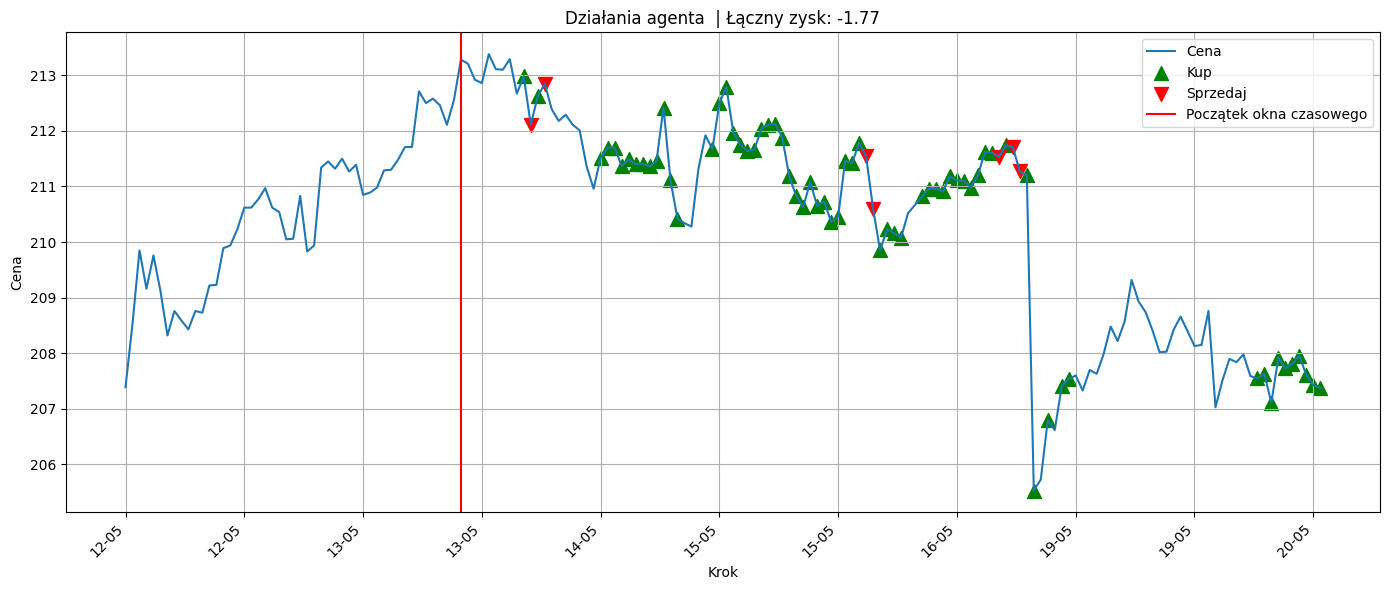

In [139]:
def evaluate_steps(env, model, device="cuda:0"):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    action = 0
    while not done:
        # konwersja stanu na tensora
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        state, reward, done = env.step(action)
        total_reward += reward
        steps += 1
        #print(f"Krok: {steps}, Akcja: {action}, Nagroda: {reward:.2f}, Łączny zysk: {env.total_profit:.2f}")

    #print(state_tensor)
    return total_reward


def render_env(env, title_suffix=""):
    prices = env.data
    buy_points = env.states_buy
    sell_points = env.states_sell
    profit = env.total_profit
    
    plt.figure(figsize=(14, 6))
    plt.plot(prices, label='Cena', linewidth=1.5)

    if buy_points:
        plt.scatter(buy_points, [prices[i] for i in buy_points],
                    color='green', marker='^', label='Kup', s=100)
    if sell_points:
        plt.scatter(sell_points, [prices[i] for i in sell_points],
                    color='red', marker='v', label='Sprzedaj', s=100)
    
    
    plt.title(f'Działania agenta {title_suffix} | Łączny zysk: {profit:.2f}')
    plt.axvline(x = 48, color = 'red', label = 'Początek okna czasowego')
    plt.xlabel('Krok')
    plt.ylabel('Cena')
    
        # Ustawianie ładniejszych dat na osi X
    step = max(1, len(test_dates_plot) // 10)  # np. co 10 punktów
    xticks_pos = list(range(0, len(test_dates_plot), step))
    #xticks_labels = [test_dates_plot[i] for i in xticks_pos]
    xticks_labels = [
        pd.to_datetime(test_dates_plot[i]).strftime('%d-%m')
        for i in xticks_pos
    ]
    plt.xticks(xticks_pos, xticks_labels, rotation=45, ha='right')
    
    
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


test_env.reset()
evaluate_steps(test_env, agent.target_model)
render_env(test_env, title_suffix="")

In [1]:
test_env.total_profit - sum(test_env.inventory -test_env.data[-1])

NameError: name 'test_env' is not defined

In [141]:
len(test_env.inventory)

60